# Dataset
https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=576

# Goals
- 단일경구약제 중 TL_81 파일의 것만 학습/분류 (13GB)
- 추후 무슨 종류의 약을 어떤 이유로 학습시키고 싶은지 구체적으로 정하도록

# Process
- import json file and train dataset image names
- Resize train dataset images to 64 x 64
- Process data from json and change to csv (np array?)
> Tags: file_name, dl+name, dl_material
- Set Model
> input_shape: (64,64,3), softmax(classification)
- Train Data
> Visualize results of Loss/Accuracy w/ matplotlib
- Compare prediction accuracy before/after training

# To-do
- Completed

In [1]:
import cv2, json, glob, os, time, tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from keras import backend as K
from keras.models import load_model

print(cv2.__version__)
print(sns.__version__)

4.7.0
0.12.1


In [2]:
#json, img 파일 제목 저장

dir_1 = glob.glob('./1.Training/라벨링데이터/단일경구약제_5000종/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')
print(json_names[:5])

temp_img_dir = glob.glob('./1.Training/images/*')
# temp_img_dir = glob.glob('./1.Training/원천데이터/단일경구약제 5000종/*')
# print(len(temp_img_dir))  #should be 24
img_names = []
for temp in temp_img_dir:
    img_names += glob.glob(temp + '/*.*')
print(img_names[:5])

['./1.Training/라벨링데이터/단일경구약제_5000종\\K-038884_json\\K-038884_0_0_0_0_75_000_200.json', './1.Training/라벨링데이터/단일경구약제_5000종\\K-038884_json\\K-038884_0_0_0_0_75_020_200.json', './1.Training/라벨링데이터/단일경구약제_5000종\\K-038884_json\\K-038884_0_0_0_0_75_040_200.json', './1.Training/라벨링데이터/단일경구약제_5000종\\K-038884_json\\K-038884_0_0_0_0_75_060_200.json', './1.Training/라벨링데이터/단일경구약제_5000종\\K-038884_json\\K-038884_0_0_0_0_75_080_200.json']
['./1.Training/images\\K-038884\\K-038884_0_0_0_0_75_000_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_020_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_040_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_060_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_080_200.png']


In [3]:
%%time
#IMG_RESIZE
#조장 김지수님 코드 기반
i = 0
# os.mkdir('Data/1.Training/images/' + 'hi')

for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = './1.Training/images/' + file_name[:8]
        # print(file_dir)
        if not os.path.isdir(file_dir):
            print('Saving directory:',file_dir) #추가
            os.mkdir(file_dir)

        file_dir = file_dir + '/' + file_name

        if not os.path.isfile(file_dir):
            # print(file_dir)
            x, y, w, h = js['annotations'][0]['bbox']

            cx = x + w // 2
            cy = y + h // 2
            w_h, h_h = max(w, h), max(w, h)  # 깨끗한 data 를 얻기 위해 크롭영역을 정방형으로 해준다. 기준은 둘 중 큰 값
            x = cx - (w_h // 2)
            y = cy - (h_h // 2)

            # print(x, y, w, h)
            img_names[idx] = img_names[idx].replace('\\', '/', 10)
            # print(img_names[idx])
            img = cv2.imread(img_names[idx], cv2.IMREAD_COLOR)
            
            cropped_img = img[y:y + h_h, x:x + w_h]
            cropped_img = cv2.resize(cropped_img, (64, 64))   #64, 64
            if idx % 100 == 0:
                print('진행상황: {} / {}'.format(idx, len(img_names)))
            cv2.imwrite(file_dir, cropped_img)
        else:
            # print(f'Data named {file_dir} already processed.')
            continue

CPU times: total: 3.45 s
Wall time: 59.6 s


In [4]:
#Import JSON files
'''
dir_1 = glob.glob('./1.Training/라벨링데이터/단일경구약제 5000종/*')
json_names = []
for temp in dir_1:
    json_names += glob.glob(temp + '/*.*')
# print(json_names[:5])
'''

#Make list by tags in JSON file
num_lst=[]  #Unique ID (K-XXXXXX)
img_lst=[]  #PNG image file name
name_lst=[] #Image saved directory
type_lst=[] #Type of pill
img_fp=[]   #Types of ingredients (구성 성분)

def json_var(list, tag):
    list.append(js['images'][0][tag])

for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)   #debug
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = './1.Training/images/' + file_name[:8]

        json_var(img_lst, 'file_name')
        json_var(name_lst, 'dl_name')
        json_var(type_lst, 'dl_material')
        num_lst.append(file_name[:8])
        img_fp.append(file_dir)

print(num_lst[:5], img_lst[:5], img_fp[:5], name_lst[:5], type_lst[:5], sep='\n')

['K-038884', 'K-038884', 'K-038884', 'K-038884', 'K-038884']
['K-038884_0_0_0_0_75_000_200.png', 'K-038884_0_0_0_0_75_020_200.png', 'K-038884_0_0_0_0_75_040_200.png', 'K-038884_0_0_0_0_75_060_200.png', 'K-038884_0_0_0_0_75_080_200.png']
['./1.Training/images/K-038884', './1.Training/images/K-038884', './1.Training/images/K-038884', './1.Training/images/K-038884', './1.Training/images/K-038884']
['에피나레정', '에피나레정', '에피나레정', '에피나레정', '에피나레정']
['에피나스틴염산염', '에피나스틴염산염', '에피나스틴염산염', '에피나스틴염산염', '에피나스틴염산염']


In [5]:
#Save PD dataframe to CSV

df_info={'num_id': num_lst, 'file_name': img_lst, 'img_dir': img_fp, 'pill_name': name_lst, 'pill_type': type_lst}
df_info=pd.DataFrame(df_info)
df_info.to_csv("./2.Sample/pill_df.csv",index=False)
df=pd.read_csv("./2.Sample/pill_df.csv")
df

,num_id,file_name,img_dir,pill_name,pill_type
0,K-038884,K-038884_0_0_0_0_75_000_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염
1,K-038884,K-038884_0_0_0_0_75_020_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염
2,K-038884,K-038884_0_0_0_0_75_040_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염
3,K-038884,K-038884_0_0_0_0_75_060_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염
4,K-038884,K-038884_0_0_0_0_75_080_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염
...,...,...,...,...,...
9607,K-039147,K-039147_0_2_1_2_90_260_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염
9608,K-039147,K-039147_0_2_1_2_90_280_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염
9609,K-039147,K-039147_0_2_1_2_90_300_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염
9610,K-039147,K-039147_0_2_1_2_90_320_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염


In [6]:
#check how many images are in each folder

cnt_by_id=df['num_id'].value_counts()
cnt_by_id

K-039147    1296
K-039146    1296
K-039136    1296
K-038954     324
K-039047     324
K-039036     324
K-039021     324
K-038967     324
K-038958     324
K-038962     324
K-038929     324
K-038927     324
K-038910     324
K-038896     324
K-038959     216
K-038890     216
K-038970     216
K-038914     216
K-038913     216
K-038912     216
K-039104     216
K-039108     216
K-039123     216
K-038884     216
Name: num_id, dtype: int64

In [7]:
# Undersampling - 데이터 불균형
# These three types are too large compared to others.
# They will be randomly sampled to 30% of original size.

large_lst=["K-039147", "K-039146", "K-039136"]

for each in large_lst:
    idx_1 = df[df['num_id'] == each] #.index
    idx_2 = idx_1.sample(frac =.70).index
    df = df.drop(idx_2)

    print(df[df['num_id'] == each].index)
    
# cnt_by_id=df['num_id'].value_counts()
# cnt_by_id.plot.bar()

Int64Index([8329, 8331, 8334, 8339, 8348, 8349, 8352, 8363, 8366, 8369,
            ...
            9576, 9577, 9580, 9591, 9599, 9601, 9603, 9604, 9607, 9608],
           dtype='int64', length=389)
Int64Index([7020, 7022, 7023, 7031, 7033, 7040, 7044, 7051, 7052, 7054,
            ...
            8281, 8282, 8285, 8286, 8299, 8302, 8304, 8307, 8311, 8313],
           dtype='int64', length=389)
Int64Index([5724, 5725, 5726, 5727, 5728, 5729, 5737, 5744, 5746, 5747,
            ...
            6996, 7000, 7001, 7002, 7003, 7006, 7010, 7012, 7013, 7014],
           dtype='int64', length=389)


<AxesSubplot: >

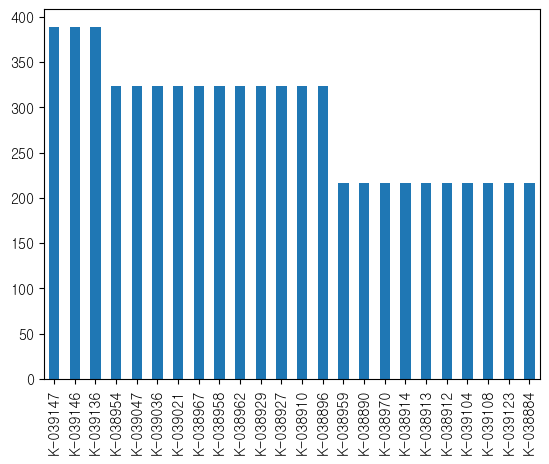

In [8]:
#Visualization by type

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

cnt_by_id=df['num_id'].value_counts()
cnt_by_id.plot.bar()

In [26]:
num = len(df['pill_name'].unique())
print(f'{ num } pill types exist in {len(df)} images.')

24 pill types exist in 6891 images.


In [10]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import colors
import random
from pathlib import Path
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import cv2

In [11]:
df['PNG'] = df['num_id'] + '/' + df['file_name']
df

,num_id,file_name,img_dir,pill_name,pill_type,PNG
0,K-038884,K-038884_0_0_0_0_75_000_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염,K-038884/K-038884_0_0_0_0_75_000_200.png
1,K-038884,K-038884_0_0_0_0_75_020_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염,K-038884/K-038884_0_0_0_0_75_020_200.png
2,K-038884,K-038884_0_0_0_0_75_040_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염,K-038884/K-038884_0_0_0_0_75_040_200.png
3,K-038884,K-038884_0_0_0_0_75_060_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염,K-038884/K-038884_0_0_0_0_75_060_200.png
4,K-038884,K-038884_0_0_0_0_75_080_200.png,./1.Training/images/K-038884,에피나레정,에피나스틴염산염,K-038884/K-038884_0_0_0_0_75_080_200.png
...,...,...,...,...,...,...
9601,K-039147,K-039147_0_2_1_2_90_140_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염,K-039147/K-039147_0_2_1_2_90_140_200.png
9603,K-039147,K-039147_0_2_1_2_90_180_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염,K-039147/K-039147_0_2_1_2_90_180_200.png
9604,K-039147,K-039147_0_2_1_2_90_200_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염,K-039147/K-039147_0_2_1_2_90_200_200.png
9607,K-039147,K-039147_0_2_1_2_90_260_200.png,./1.Training/images/K-039147,듀카브정30/10밀리그램,피마사르탄칼륨삼수화물과립|암로디핀베실산염,K-039147/K-039147_0_2_1_2_90_260_200.png


In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['pill_name'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['pill_name'])

print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 4409
Test  set rows: 1379
Val   set rows: 1103


In [13]:
IMAGE_PATH = "./1.Training/images/"

def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image1 = skimage.transform.resize(image, (64, 64), mode='reflect')
    return image1[:,:,:3]

In [14]:
def categories_encoder(dataset, var='pill_name'):
    X = np.stack(dataset['PNG'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [15]:
%%time

X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

CPU times: total: 11.2 s
Wall time: 13.7 s


In [16]:
model = tf.keras.models.Sequential()
# conv 1
model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu',input_shape=(64,64,3)))
model.add(tf.keras.layers.Dropout(rate=0.5))                          #  DO1
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# conv 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))                          # DO2
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# conv 3
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))                           # DO3
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                    

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(patience = 4, verbose=1)

# checkpointer1 = ModelCheckpoint('best_model1.h5'
#                                 ,monitor='val_acc'
#                                 ,verbose=1
#                                 ,save_best_only=True
#                                 ,save_weights_only=True)

train_model1 = model.fit(X_train, y_train, epochs=8,
                            validation_data=(X_val, y_val))

# model.load_weights('best_model1.h5')

Epoch 1/8
138/138 [==============================] - 53s 375ms/step - loss: 1.7091 - accuracy: 0.4114 - val_loss: 1.8504 - val_accuracy: 0.5839
Epoch 2/8
138/138 [==============================] - 54s 392ms/step - loss: 0.6695 - accuracy: 0.7131 - val_loss: 1.6920 - val_accuracy: 0.5712
Epoch 3/8
138/138 [==============================] - 52s 375ms/step - loss: 0.5780 - accuracy: 0.7437 - val_loss: 1.5805 - val_accuracy: 0.6609
Epoch 4/8
138/138 [==============================] - 52s 379ms/step - loss: 0.5149 - accuracy: 0.7643 - val_loss: 1.5209 - val_accuracy: 0.7189
Epoch 5/8
138/138 [==============================] - 53s 387ms/step - loss: 0.4898 - accuracy: 0.7750 - val_loss: 1.4433 - val_accuracy: 0.6646
Epoch 6/8
138/138 [==============================] - 51s 369ms/step - loss: 0.4899 - accuracy: 0.7775 - val_loss: 1.3878 - val_accuracy: 0.7208
Epoch 7/8
138/138 [==============================] - 50s 363ms/step - loss: 0.4379 - accuracy: 0.7972 - val_loss: 1.2828 - val_accuracy:

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3172019720077515
Test accuracy: 0.7200869917869568


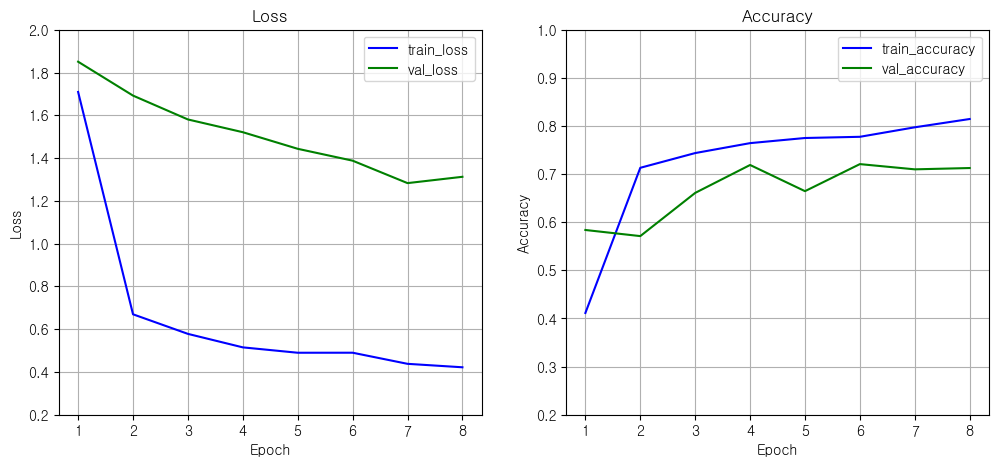

In [20]:
loss = train_model1.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(epochs, train_model1.history['loss'], 'b', label='train_loss')
plt.plot(epochs, train_model1.history['val_loss'], 'g', label='val_loss')
plt.ylim([0.2,2])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(epochs, train_model1.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, train_model1.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0.2,1])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()